In [1]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from snr.calc_snr import str2snr_strategy
from dataset_creation.noisy_dataset import create_single_noisy_version
from dataset_creation.utils import get_n_random_noises

# Create a Noisy Dataset

## Requirements And Configuration

The generated noisy traces should be a synthetic version of traces taken from the following dataset ('ethz', 'geofon'):

In [2]:
DATASETS_ORIGINS = ['ethz', 'geofon']
dataset_origin = 'ethz'
assert dataset_origin in DATASETS_ORIGINS, f'Expected dataset one of {DATASETS_ORIGINS}. Got {dataset_origin}.'

In [3]:
NUM_SAMPLES=3001                    # Trace sample length - If the dataset is built for phasenet: 3001 If it is for EQTransformer: 6000
NUM_NOISY_VERSIONS_PER_TRACE=1      # How many noisy versions to synthesize using a single real trace
DESIRED_SNR=7                      # What SNR level should the noisy synthesized trace be
SAMPLING_RATE=100                   # Sampling Rate - PhaseNet and EQTransformer expect 100Hz
NUM_OF_ORIGINAL_TRACES = 2100       # How many original traces to use for the noisy dataset - use slice from the start

In [4]:
SNR_CALC_STRATEGY_STR_ALTERNATIVES = ['energy_ratio', 'max_amplitude_vs_rms_ratio']
SNR_CALC_STRATEGY_STR = 'max_amplitude_vs_rms_ratio'
assert SNR_CALC_STRATEGY_STR in SNR_CALC_STRATEGY_STR_ALTERNATIVES, f'Expected one of {SNR_CALC_STRATEGY_STR_ALTERNATIVES}. Got {SNR_CALC_STRATEGY_STR}'
SNR_CALC_STRATEGY=str2snr_strategy(SNR_CALC_STRATEGY_STR)  # Function used to estimate the trace Signal to Noise Ratio(SNR) -  ENERGY_RATIO orMAX_AMPLITUDE_VS_RMS_RATIO
SNR_CALC_STRATEGY

<SnrCalcStrategy.MAX_AMPLITUDE_VS_RMS_RATIO: 2>

If the generated noises should allow shifting experiments they should be longer than the original trace.
Define how many 1-second-shifts will the dataset enable.

In [5]:
NUM_SHIFTS=6
AUGMENTED_WINDOW_SIZE=NUM_SAMPLES+SAMPLING_RATE*NUM_SHIFTS

Browse The path of the **event** traces that will be used for synthesizing.

In [6]:
DATASET_PATH=f'/home/moshe/datasets/GFZ/noisy_datasets/{dataset_origin}_{NUM_SAMPLES}_sample_joachim_noises_{SNR_CALC_STRATEGY_STR}_snr/'

Browse The path of the **noise** traces that will be used for synthesizing.

In [7]:
NOISES_PATH='/home/moshe/datasets/GFZ/Noises'

In [8]:
dataset_traces_path = os.path.join(DATASET_PATH, 'original_dataset.pt')[:NUM_OF_ORIGINAL_TRACES]
dataset_labels_path = os.path.join(DATASET_PATH, 'original_labels.pt')[:NUM_OF_ORIGINAL_TRACES]

assert os.path.exists(DATASET_PATH), f'Directory {DATASET_PATH} does not exist'
assert os.path.exists(dataset_traces_path), f'file {dataset_traces_path} does not exist'
assert os.path.exists(dataset_labels_path), f'file {dataset_labels_path} does not exist'

## Load Dataset

In [9]:
dataset=torch.load(dataset_traces_path)[:NUM_OF_ORIGINAL_TRACES]
labels=torch.load(dataset_labels_path)[:NUM_OF_ORIGINAL_TRACES]

num_traces = dataset.shape[0]
num_labels = labels.shape[0]
num_samples = dataset.shape[-1]

assert num_labels==num_traces, f'Expected traces equal num labels.Got {num_traces} traces and {num_labels} labels'
assert num_samples==NUM_SAMPLES, f'Expected {NUM_SAMPLES} in each trace. Got {num_samples}.'

print(f'Loaded {num_traces} traces and corresponding labels.')

Loaded 2100 traces and corresponding labels.


## Create a Noisy Dataset

In [10]:
noised_traces_list, noised_traces_labels_list, augmented_noise_traces_list, factors_list, indices_not_used_list = [],[],[],[], []
pbar = tqdm(range(NUM_NOISY_VERSIONS_PER_TRACE))
for i in pbar:
    # prepare full noises traces
    augmented_noise_traces_created: torch.tensor = get_n_random_noises(num_noises=num_traces, desired_window_size=AUGMENTED_WINDOW_SIZE, noises_path=NOISES_PATH, force_resample=True, filename='aaa', sampling_rate=SAMPLING_RATE, silent_exception_prints=True).squeeze()

    version_noised_traces, version_labels, version_full_noise_traces, version_factors, version_not_included_indices =  create_single_noisy_version(original_traces=dataset, original_labels=labels, augmented_noise_traces=augmented_noise_traces_created, desired_snr=DESIRED_SNR, snr_startegy=SNR_CALC_STRATEGY)
    noised_traces_list.append(version_noised_traces)
    noised_traces_labels_list.append(version_labels.unsqueeze(dim=1))
    augmented_noise_traces_list.append(version_full_noise_traces)
    factors_list.append(version_factors.unsqueeze(dim=1))
    indices_not_used_list.extend(version_not_included_indices)
    pbar.set_description(f'Lists len {len(noised_traces_list), len(noised_traces_labels_list), len(augmented_noise_traces_list), len(factors_list)}')

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 2100/2100 [00:17<00:00, 116.93it/s]


Created a list of 2100 random noises of shape torch.Size([3, 3601])
stack to tensor
Stacked to tensor of shape torch.Size([2100, 3, 3601])
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:08<00:00, 244.46it/s]


Created 2050 noisy traces
The following indices are not included [81, 97, 166, 285, 355, 369, 392, 527, 582, 710, 754, 776, 800, 837, 855, 888, 923, 928, 935, 937, 943, 1091, 1164, 1248, 1258, 1271, 1329, 1343, 1353, 1415, 1416, 1428, 1440, 1468, 1497, 1509, 1530, 1625, 1663, 1762, 1818, 1838, 1855, 1890, 1892, 1903, 1921, 2034, 2043, 2074]


In [11]:
noised_traces = torch.vstack(noised_traces_list)
noised_traces_labels = torch.vstack(noised_traces_labels_list).squeeze()
augmented_noise_traces = torch.vstack(augmented_noise_traces_list)
noising_factors = torch.vstack(factors_list).squeeze()
indices_not_used = torch.tensor(list(set(indices_not_used_list)))
noised_traces.shape, noised_traces_labels.shape, augmented_noise_traces.shape, noising_factors.shape, indices_not_used.shape

(torch.Size([2050, 3, 3001]),
 torch.Size([2050]),
 torch.Size([2050, 3, 3601]),
 torch.Size([2050]),
 torch.Size([50]))

In [12]:
noisy_dataset_path = os.path.join(DATASET_PATH,f'noisy_dataset_snr_{DESIRED_SNR}')
noisy_dataset_path

'/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_max_amplitude_vs_rms_ratio_snr/noisy_dataset_snr_7'

## Save Noisy Indices To Files

In [13]:
assert os.path.exists(noisy_dataset_path), f'Path {noisy_dataset_path} does not exist.Create it'

In [14]:
torch.save(noised_traces, os.path.join(noisy_dataset_path, 'traces.pt'))
torch.save(augmented_noise_traces, os.path.join(noisy_dataset_path, 'full_noise_traces.pt'))
torch.save(noised_traces_labels, os.path.join(noisy_dataset_path, 'labels.pt'))
torch.save(noising_factors, os.path.join(noisy_dataset_path, 'factors.pt'))
torch.save(indices_not_used, os.path.join(noisy_dataset_path,'indices_not_used'))

## Plot Noising Example

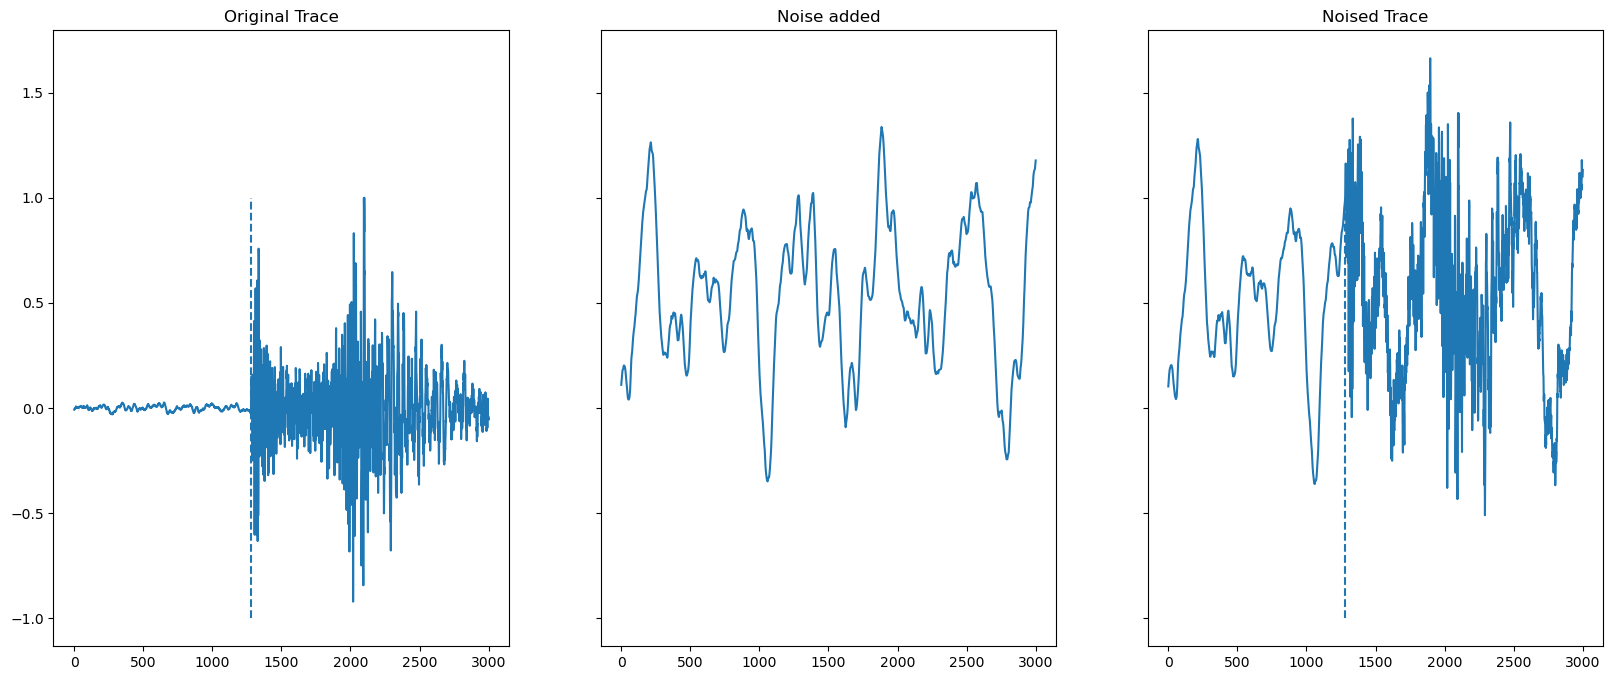

In [15]:
idx = 5
trace  = noised_traces[idx]
label  = noised_traces_labels[idx]
factor = noising_factors[idx]
noise = augmented_noise_traces[idx, :, :trace.shape[-1] ]

fig, (ax_orig,ax_noise, ax_noised) = plt.subplots(1,3,figsize=(20,8), sharey='all')

ax_orig.plot((trace - factor * noise)[0]);
ax_orig.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');
ax_orig.set_title('Original Trace')
ax_noise.plot(factor*noise[0]);
ax_noise.set_title('Noise added')
ax_noised.plot(trace[0]);
ax_noised.set_title('Noised Trace')

ax_noised.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');

## A Unified Version of The Noisy Datasets

For metrics benchmark it is preferred to create several SNR datasets using the same noises. For each SNR, a single noisy version is created.

First, prepare the noise that will be used for all SNR levels.

In [16]:
# prepare full noises traces
augmented_noise_traces_created: torch.tensor = get_n_random_noises(num_noises=num_traces, desired_window_size=AUGMENTED_WINDOW_SIZE, noises_path=NOISES_PATH, force_resample=True, filename='aaa', sampling_rate=SAMPLING_RATE, silent_exception_prints=True).squeeze()

100%|██████████| 2100/2100 [00:15<00:00, 132.88it/s]


Created a list of 2100 random noises of shape torch.Size([3, 3601])
stack to tensor
Stacked to tensor of shape torch.Size([2100, 3, 3601])


In [17]:
desired_snr_list = list(range(2,11))
noisy_dataset_paths = {}
for desired_snr in desired_snr_list:
    noisy_dataset_path = os.path.join(DATASET_PATH,f'noisy_dataset_snr_{desired_snr}')
    assert os.path.exists(noisy_dataset_path), f'Path {noisy_dataset_path} does not exist.Create it'
    noisy_dataset_paths[desired_snr] = noisy_dataset_path

pbar = tqdm(desired_snr_list)
for desired_snr in pbar:
    noised_traces, noised_traces_labels, full_noise_traces_used, factors, indices_not_used_list =  create_single_noisy_version(original_traces=dataset, original_labels=labels, augmented_noise_traces=augmented_noise_traces_created, desired_snr=desired_snr, snr_startegy=SNR_CALC_STRATEGY)

    indices_not_used = torch.tensor(list(set(indices_not_used_list)))
    noisy_dataset_path = noisy_dataset_paths[desired_snr]
    torch.save(noised_traces, os.path.join(noisy_dataset_path, 'traces.pt'))
    torch.save(augmented_noise_traces, os.path.join(noisy_dataset_path, 'full_noise_traces.pt'))
    torch.save(noised_traces_labels, os.path.join(noisy_dataset_path, 'labels.pt'))
    torch.save(noising_factors, os.path.join(noisy_dataset_path, 'factors.pt'))
    torch.save(indices_not_used, os.path.join(noisy_dataset_path,'indices_not_used'))
    pbar.set_description(f'SNR {desired_snr}: {noised_traces.shape[0]} noised traces created and saved.')
    del noised_traces, noised_traces_labels, full_noise_traces_used, factors, indices_not_used_list , indices_not_used

  0%|          | 0/9 [00:00<?, ?it/s]

Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:48<00:00, 43.44it/s]


Created 1382 noisy traces
The following indices are not included [0, 2, 4, 6, 10, 12, 13, 20, 26, 28, 29, 30, 32, 34, 35, 40, 44, 45, 47, 52, 58, 60, 62, 66, 69, 70, 71, 73, 81, 84, 87, 88, 96, 101, 102, 104, 107, 112, 118, 119, 124, 127, 129, 130, 137, 144, 148, 151, 152, 155, 158, 162, 167, 168, 171, 176, 181, 183, 185, 186, 187, 189, 191, 195, 197, 203, 205, 209, 218, 219, 221, 224, 225, 227, 228, 231, 233, 235, 236, 239, 244, 246, 251, 252, 264, 265, 270, 276, 280, 282, 290, 291, 293, 296, 301, 302, 306, 307, 311, 314, 324, 326, 327, 329, 330, 331, 332, 338, 343, 347, 348, 352, 353, 357, 359, 361, 367, 371, 372, 381, 385, 390, 391, 393, 394, 395, 400, 401, 402, 403, 408, 409, 411, 413, 414, 416, 426, 432, 441, 443, 444, 445, 449, 450, 453, 454, 458, 465, 470, 472, 474, 476, 479, 480, 482, 484, 485, 487, 490, 492, 493, 494, 497, 503, 505, 507, 510, 514, 519, 520, 522, 527, 531, 532, 534, 535, 539, 541, 545, 547, 548, 552, 553, 554, 555, 560, 563, 565, 566, 567, 570, 573, 574, 578, 5


100%|██████████| 2100/2100 [00:33<00:00, 62.66it/s]


Created 1619 noisy traces
The following indices are not included [4, 6, 10, 12, 13, 20, 26, 28, 30, 34, 35, 40, 47, 52, 58, 62, 66, 69, 70, 71, 73, 84, 87, 88, 96, 101, 102, 104, 107, 118, 119, 124, 127, 130, 137, 144, 151, 155, 158, 162, 168, 171, 176, 183, 185, 189, 195, 205, 209, 219, 221, 224, 225, 228, 235, 236, 239, 251, 252, 264, 270, 276, 280, 282, 290, 291, 296, 301, 302, 306, 311, 324, 326, 327, 329, 330, 331, 332, 338, 343, 347, 353, 359, 367, 371, 381, 385, 393, 394, 400, 401, 402, 403, 432, 441, 443, 444, 445, 449, 453, 454, 465, 474, 476, 479, 482, 485, 492, 494, 503, 505, 510, 514, 519, 520, 527, 531, 535, 539, 541, 548, 552, 553, 554, 560, 563, 565, 570, 574, 578, 580, 584, 585, 595, 596, 598, 607, 619, 628, 630, 631, 633, 635, 637, 644, 646, 648, 653, 655, 656, 658, 668, 673, 674, 675, 685, 686, 690, 692, 695, 702, 705, 720, 722, 725, 728, 731, 737, 741, 743, 748, 754, 758, 771, 773, 774, 782, 784, 800, 802, 806, 808, 809, 816, 817, 818, 820, 826, 835, 849, 851, 855, 8


100%|██████████| 2100/2100 [00:21<00:00, 97.06it/s]


Created 1820 noisy traces
The following indices are not included [6, 10, 20, 28, 30, 35, 40, 52, 58, 69, 73, 96, 101, 104, 107, 124, 127, 137, 151, 158, 162, 185, 209, 219, 239, 251, 276, 280, 290, 291, 301, 302, 306, 311, 324, 327, 329, 332, 338, 347, 353, 381, 385, 393, 401, 402, 403, 432, 449, 453, 454, 476, 479, 482, 485, 492, 505, 519, 531, 541, 548, 554, 563, 574, 578, 580, 585, 598, 628, 633, 635, 644, 648, 658, 673, 675, 685, 690, 692, 720, 731, 737, 741, 773, 802, 806, 808, 809, 816, 817, 818, 820, 826, 849, 855, 857, 862, 867, 872, 873, 874, 876, 886, 890, 906, 910, 912, 915, 920, 925, 946, 950, 956, 961, 963, 976, 977, 978, 984, 986, 994, 1003, 1004, 1012, 1014, 1027, 1041, 1051, 1058, 1067, 1071, 1081, 1082, 1102, 1106, 1109, 1110, 1123, 1127, 1139, 1140, 1145, 1146, 1150, 1160, 1168, 1172, 1173, 1179, 1180, 1187, 1193, 1204, 1206, 1208, 1209, 1219, 1223, 1226, 1229, 1239, 1242, 1243, 1248, 1253, 1255, 1259, 1260, 1278, 1281, 1282, 1291, 1296, 1317, 1318, 1325, 1332, 1343, 


100%|██████████| 2100/2100 [00:14<00:00, 142.54it/s][A


Created 1946 noisy traces
The following indices are not included [6, 20, 28, 30, 35, 58, 69, 73, 96, 101, 104, 107, 124, 127, 151, 158, 219, 239, 251, 291, 301, 306, 311, 381, 393, 401, 402, 403, 432, 453, 454, 482, 505, 531, 541, 554, 580, 585, 598, 635, 648, 658, 673, 675, 690, 731, 773, 806, 808, 809, 817, 818, 820, 849, 873, 874, 876, 886, 890, 906, 912, 915, 925, 946, 950, 976, 977, 978, 984, 986, 994, 1004, 1012, 1027, 1058, 1071, 1109, 1110, 1146, 1150, 1160, 1172, 1173, 1187, 1193, 1204, 1206, 1208, 1219, 1226, 1239, 1243, 1248, 1253, 1255, 1259, 1260, 1278, 1318, 1325, 1332, 1343, 1357, 1365, 1377, 1380, 1395, 1404, 1437, 1442, 1468, 1528, 1552, 1558, 1562, 1565, 1590, 1628, 1663, 1665, 1682, 1726, 1728, 1731, 1732, 1737, 1767, 1787, 1803, 1807, 1834, 1846, 1878, 1895, 1899, 1907, 1908, 1934, 1947, 1959, 1976, 1980, 1984, 2005, 2009, 2014, 2038, 2040, 2042, 2049, 2054, 2055, 2063, 2073]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:11<00:00, 189.69it/s]


Created 2003 noisy traces
The following indices are not included [30, 35, 58, 73, 124, 127, 151, 158, 219, 251, 306, 311, 381, 393, 401, 432, 453, 482, 531, 541, 598, 635, 648, 658, 673, 675, 690, 731, 773, 806, 809, 820, 849, 873, 874, 876, 886, 890, 946, 950, 976, 977, 984, 986, 994, 1004, 1027, 1058, 1071, 1110, 1146, 1150, 1172, 1193, 1206, 1219, 1239, 1243, 1248, 1259, 1260, 1278, 1318, 1332, 1365, 1377, 1395, 1437, 1442, 1468, 1528, 1552, 1558, 1562, 1565, 1590, 1628, 1663, 1665, 1682, 1726, 1731, 1737, 1767, 1787, 1807, 1878, 1899, 1907, 1908, 1934, 1947, 1959, 2009, 2014, 2040, 2073]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:07<00:00, 263.15it/s]


Created 2052 noisy traces
The following indices are not included [35, 58, 73, 124, 158, 219, 251, 453, 482, 598, 648, 658, 773, 806, 873, 876, 886, 890, 946, 977, 984, 986, 994, 1004, 1058, 1146, 1150, 1172, 1193, 1206, 1219, 1248, 1259, 1278, 1332, 1395, 1468, 1562, 1565, 1628, 1663, 1726, 1737, 1767, 1807, 1899, 1908, 1934]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:06<00:00, 332.61it/s]


Created 2083 noisy traces
The following indices are not included [124, 251, 453, 482, 598, 658, 873, 890, 977, 986, 1146, 1206, 1259, 1395, 1663, 1807, 1899]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:05<00:00, 361.32it/s]


Created 2092 noisy traces
The following indices are not included [124, 251, 482, 986, 1146, 1259, 1395, 1807]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:05<00:00, 388.46it/s]


Created 2098 noisy traces
The following indices are not included [482, 1807]
